<h1>Classifying the Truthfulness of Tweets About Climate Change</h1>
<p>Haley Johnson</p>
<p>STATS 315 Final Project</p>

In [1]:
!pip uninstall scikit-learn -y
!pip install -U scikit-learn===1.2.0
!pip install langdetect
!pip install bert
!pip install emoji
!pip install bert-tensorflow===1.0.1
!pip install transformers
!pip install sparse
!pip install tokenization

Found existing installation: scikit-learn 1.2.0
Uninstalling scikit-learn-1.2.0:
  Successfully uninstalled scikit-learn-1.2.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scikit_learn-1.2.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.7 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-whe

In [2]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import gensim.downloader
import os
import json
import bert
import sklearn
import nltk
from nltk.corpus import stopwords

from bert.tokenization import FullTokenizer



from tensorflow import keras 
import tensorflow_hub as hub
from tensorflow.keras import layers, Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, SimpleRNN, BatchNormalization, GlobalAveragePooling1D, GlobalMaxPooling1D, TextVectorization, Dropout, LSTM, Bidirectional, GRU, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

In [3]:
tf.gfile = tf.io.gfile

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%cd /content/drive/MyDrive/stats_315_final_proj
from helper_functions import *

/content/drive/MyDrive/stats_315_final_proj


In [6]:
%cd /content/drive/MyDrive/stats_315_final_proj/data
df = pd.read_csv("cleaned_text.csv")

/content/drive/MyDrive/stats_315_final_proj/data


<h2>Train/Test/Validate Split</h2>

In [7]:
X = df.message_cleaned
y = df.sentiment
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)

#0.85 * 0.17647 = 0.15 validation split
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size = 0.17647, random_state = 42) 

In [8]:
X_train, y_train = balance_classes(X_train, y_train)

<h2>Logistic Regression Baseline</h2>

In [12]:
enc = sklearn.preprocessing.OneHotEncoder(handle_unknown = 'ignore', sparse_output = False, max_categories = 5000)

X_train_input = enc.fit_transform(np.array(X_train).reshape(-1, 1))
X_test_input = enc.transform(np.array(X_test).reshape(-1, 1))
X_val_input = enc.transform(np.array(X_val).reshape(-1, 1))

In [13]:
lr = LogisticRegression(max_iter = 500)
lr = lr.fit(X_train_input, y_train)

In [15]:
y_pred_test = lr.predict(X_test_input)
accuracy_score(y_test, y_pred_test)

0.22104921227870716

In [14]:
y_pred_val = lr.predict(X_val_input)
accuracy_score(y_val, y_pred_val)

0.21568945915218452

In [17]:
preds_df = pd.concat([pd.Series(y_pred_test), y_test.reset_index(drop = True)], axis = 1)
preds_df.columns = ['predicted', 'true']

In [20]:
# percent predicted as 'news'
preds_df[preds_df.predicted == 2].shape[0] / preds_df.shape[0]

0.9477018028260517

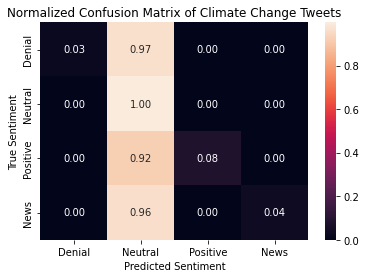

In [19]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred_test), "baseline_confusion_matrix")

<h2>GLOVE Embeddings</h2>

In [21]:
MAX_LEN = X_train.apply(len).max()

In [22]:
balanced_tokenizer = Tokenizer(num_words = 10000)
balanced_tokenizer.fit_on_texts(X_train)
balanced_conf = conf = balanced_tokenizer.get_config()
tokens_balanced = balanced_tokenizer.texts_to_sequences(X_train)
X_train_tokens = [pad_inputs(s, MAX_LEN) for s in tokens_balanced]

In [23]:
word2vec = gensim.downloader.load('glove-twitter-100')

[=================================================-] 99.5% 385.2/387.1MB downloaded


In [24]:
EMBEDDING_SIZE = word2vec['tweet'].shape[0]
NUM_CLASSES = y_train.nunique() 
VOCAB = json.loads(balanced_conf['word_index']).keys()
VOCAB_SIZE = len(VOCAB) + 1

In [25]:
w2v_weights = get_embeddings(word2vec, VOCAB, VOCAB_SIZE, EMBEDDING_SIZE)

In [26]:
X_train_input, y_train_input, X_test_input, y_test_input, X_val_input, y_val_input = get_glove_embedding_input(X_train_tokens, y_train, X_test, y_test, X_val, y_val, balanced_tokenizer, MAX_LEN, NUM_CLASSES) 

<h3>Model 1</h3>

In [30]:
model1 = Sequential([
    Embedding(input_dim = VOCAB_SIZE, output_dim = EMBEDDING_SIZE, 
              input_length = MAX_LEN, trainable = False,
              embeddings_initializer = tf.keras.initializers.Constant(w2v_weights)),
    LSTM(units = 1028, activation = 'relu', return_sequences = True),
    LSTM(units = 512, activation = 'relu', recurrent_dropout = 0.1, return_sequences = True),
    LSTM(units = 256, activation = 'relu', return_sequences = True),
    LSTM(units = 256, activation = 'relu', recurrent_dropout= 0.1, return_sequences = True),
    LSTM(units = 128, activation = 'relu', return_sequences = False),
    Dense(64, activation = 'relu'), 
    Dense(NUM_CLASSES, activation = 'softmax')
])
opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
model1.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 5)
model_checkpoint = ModelCheckpoint('model1_v2', monitor = 'val_loss', save_best_only = True, mode = 'min')

In [28]:
model1_history = model1.fit(X_train_input, y_train_input, epochs = 100, batch_size = 32, 
                            callbacks = [early_stopping, model_checkpoint],
                            validation_data = (X_val_input, y_val_input))

NameError: ignored

In [31]:
model1.load_weights('model1_v2')

In [32]:
model1.evaluate(np.array(X_test_input), y_test_input)

193/193 [==============================] - 35s 162ms/step - loss: 1.2873 - accuracy: 0.3742


[1.2873244285583496, 0.3742082118988037]

In [33]:
model1.evaluate(np.array(X_val_input), y_val_input)

193/193 [==============================] - 31s 160ms/step - loss: 1.2938 - accuracy: 0.3675


[1.293796181678772, 0.3675491213798523]

In [ ]:
model1_predictions = model1.predict(np.array(X_test_input))

193/193 [==============================] - 29s 152ms/step


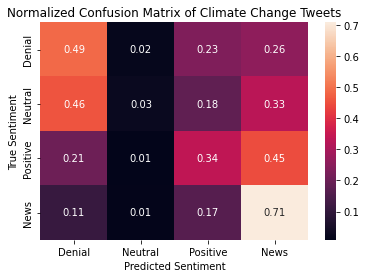

In [ ]:
plot_confusion_matrix(confusion_matrix(np.array(y_test - 1).reshape(-1, 1), model1_predictions.argmax(axis = 1)), 
                      "model_1_confusion_matrix_v2")

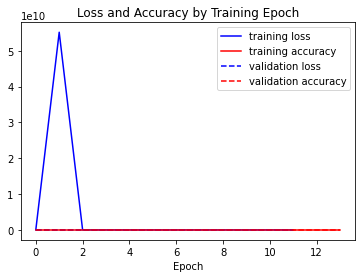

In [ ]:
plot_history(range(len(model1_history.history['accuracy'])), model1_history, 'model1_v2')

<h3>Model 2</h3>


In [34]:
model2 = Sequential([
    Embedding(input_dim = VOCAB_SIZE, output_dim = EMBEDDING_SIZE, 
              input_length = MAX_LEN, trainable = False,
              embeddings_initializer = tf.keras.initializers.Constant(w2v_weights)),
    Bidirectional(GRU(512, return_sequences = True, recurrent_activation = 'sigmoid')), 
    GlobalAveragePooling1D(),
    Dense(128, activation = 'relu'), 
    Dense(64, activation = 'relu'),
    Dense(NUM_CLASSES, activation = 'softmax')
])

opt = tf.keras.optimizers.Adam()
model2.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 3, restore_best_weights = False)
model_checkpoint = ModelCheckpoint('model_2_v2', monitor = 'val_loss', save_best_only = True, mode = 'min')

model2_history = model2.fit(X_train_input, y_train_input, epochs = 100, batch_size = 128, 
                            callbacks = [model_checkpoint, early_stopping],
                            validation_data = (X_val_input, y_val_input))

Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 1.3818 - accuracy: 0.2845

21/21 [==============================] - 20s 823ms/step - loss: 1.3818 - accuracy: 0.2845 - val_loss: 1.4140 - val_accuracy: 0.2128
Epoch 2/100
21/21 [==============================] - ETA: 0s - loss: 1.3398 - accuracy: 0.3617

21/21 [==============================] - 16s 781ms/step - loss: 1.3398 - accuracy: 0.3617 - val_loss: 1.3689 - val_accuracy: 0.2813
Epoch 3/100
21/21 [==============================] - 4s 171ms/step - loss: 1.3041 - accuracy: 0.3924 - val_loss: 1.4048 - val_accuracy: 0.2852
Epoch 4/100
21/21 [==============================] - ETA: 0s - loss: 1.2699 - accuracy: 0.4096

21/21 [==============================] - 17s 864ms/step - loss: 1.2699 - accuracy: 0.4096 - val_loss: 1.3633 - val_accuracy: 0.3901
Epoch 5/100
21/21 [==============================] - ETA: 0s - loss: 1.5414 - accuracy: 0.4025

21/21 [==============================] - 16s 807ms/step - loss: 1.5414 - accuracy: 0.4025 - val_loss: 1.3550 - val_accuracy: 0.3239
Epoch 6/100
21/21 [==============================] - ETA: 0s - loss: 1.2902 - accuracy: 0.3905

21/21 [==============================] - 16s 777ms/step - loss: 1.2902 - accuracy: 0.3905 - val_loss: 1.3304 - val_accuracy: 0.3866
Epoch 7/100
21/21 [==============================] - 4s 170ms/step - loss: 1.2547 - accuracy: 0.4261 - val_loss: 1.3805 - val_accuracy: 0.3604
Epoch 8/100
21/21 [==============================] - 4s 175ms/step - loss: 1.2215 - accuracy: 0.4433 - val_loss: 1.3633 - val_accuracy: 0.3727
Epoch 9/100
21/21 [==============================] - ETA: 0s - loss: 1.2124 - accuracy: 0.4586

21/21 [==============================] - 18s 914ms/step - loss: 1.2124 - accuracy: 0.4586 - val_loss: 1.3100 - val_accuracy: 0.4007
Epoch 10/100
21/21 [==============================] - 4s 171ms/step - loss: 1.1892 - accuracy: 0.4680 - val_loss: 1.3960 - val_accuracy: 0.3784
Epoch 11/100
21/21 [==============================] - 3s 169ms/step - loss: 1.1600 - accuracy: 0.4882 - val_loss: 1.3583 - val_accuracy: 0.3916
Epoch 12/100
21/21 [==============================] - 3s 170ms/step - loss: 1.1578 - accuracy: 0.4845 - val_loss: 1.3925 - val_accuracy: 0.3524


In [35]:
model2.load_weights("model_2_v2")

In [36]:
model2.evaluate(X_test_input, y_test_input)

193/193 [==============================] - 10s 22ms/step - loss: 1.3001 - accuracy: 0.4086


[1.3000915050506592, 0.4086405634880066]

In [37]:
model2.evaluate(X_val_input, y_val_input)

193/193 [==============================] - 3s 16ms/step - loss: 1.3100 - accuracy: 0.4007


[1.310046911239624, 0.40068215131759644]

193/193 [==============================] - 3s 15ms/step


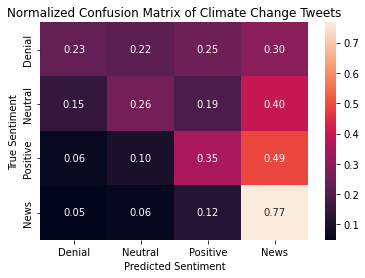

In [ ]:
model2_predictions = model2.predict(X_test_input)
plot_confusion_matrix(confusion_matrix(np.array(y_test - 1).reshape(-1, 1), model2_predictions.argmax(axis = 1)), "model_2_conf_matrix")

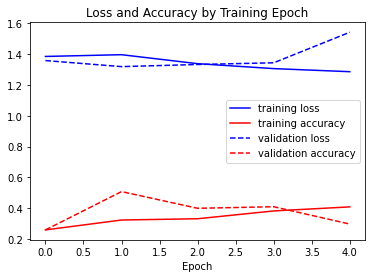

In [ ]:
plot_history(range(len(model2_history.history['accuracy'])), model2_history, 'model2_v2')

<h3>Non Sequential Model With GLOVE Embeddings</h3>

In [38]:
def build_non_sequential_model(NUM_CLASSES, VOCAB_SIZE, EMBEDDING_SIZE, MAX_LEN, w2v_weights):
    input = tf.keras.layers.Input(shape = (148,))

    x = Embedding(input_dim = VOCAB_SIZE, output_dim = EMBEDDING_SIZE, 
                  input_length = MAX_LEN, trainable = False,
                  embeddings_initializer = tf.keras.initializers.Constant(w2v_weights))(input)

    x1 = SpatialDropout1D(0.1)(x)
    x1 = Bidirectional(GRU(256, return_sequences = True, recurrent_activation = 'sigmoid'))(x1)
    x1 = GlobalAveragePooling1D()(x1)

    x2 = SpatialDropout1D(0.1)(x)
    x2 = Bidirectional(GRU(256, return_sequences = True, recurrent_activation = 'sigmoid'))(x2)
    x2 = GlobalMaxPooling1D()(x2)

    x = x1 + x2 
    x = Dense(128, activation = 'relu')(x)
    x = Dense(32, activation = 'relu')(x)
    output = Dense(NUM_CLASSES, activation = 'softmax')(x)

    model = tf.keras.models.Model(inputs = input, outputs = output)
    return model 

In [39]:
model3 = build_non_sequential_model(NUM_CLASSES, VOCAB_SIZE, EMBEDDING_SIZE, MAX_LEN, w2v_weights)
opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
model3.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 3, restore_best_weights = False)
model_checkpoint = ModelCheckpoint('model_3', monitor = 'val_loss', save_best_only = True, mode = 'min')

model3_history = model3.fit(X_train_input, y_train_input, epochs = 100, batch_size = 64, 
                            callbacks = [model_checkpoint, early_stopping],
                            validation_data = (X_val_input, y_val_input))

Epoch 1/100
42/42 [==============================] - ETA: 0s - loss: 1.3715 - accuracy: 0.2999

42/42 [==============================] - 155s 4s/step - loss: 1.3715 - accuracy: 0.2999 - val_loss: 1.2293 - val_accuracy: 0.4577
Epoch 2/100
42/42 [==============================] - 116s 3s/step - loss: 1.3125 - accuracy: 0.3909 - val_loss: 1.3144 - val_accuracy: 0.3203
Epoch 3/100
42/42 [==============================] - 116s 3s/step - loss: 1.2559 - accuracy: 0.4350 - val_loss: 1.2808 - val_accuracy: 0.4283
Epoch 4/100
42/42 [==============================] - 112s 3s/step - loss: 1.1606 - accuracy: 0.5204 - val_loss: 1.2322 - val_accuracy: 0.4395


In [40]:
model3.load_weights("model_3")

In [41]:
model3.evaluate(X_test_input, y_test_input)

193/193 [==============================] - 9s 25ms/step - loss: 1.2284 - accuracy: 0.4553


[1.2283991575241089, 0.4552541971206665]

In [42]:
model3.evaluate(X_val_input, y_val_input)

193/193 [==============================] - 3s 16ms/step - loss: 1.2293 - accuracy: 0.4577


[1.2292646169662476, 0.45769044756889343]

193/193 [==============================] - 61s 309ms/step


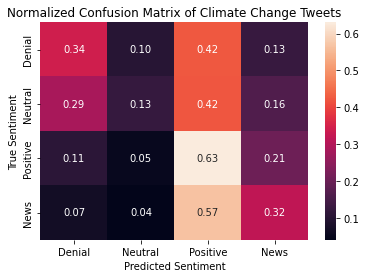

In [ ]:
model3_predictions = model3.predict(X_test_input)
plot_confusion_matrix(confusion_matrix(np.array(y_test - 1).reshape(-1, 1), model3_predictions.argmax(axis = 1)), "model_3_conf_matrix")

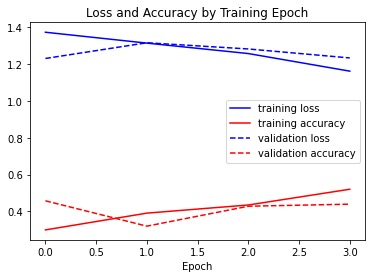

In [ ]:
plot_history(range(len(model3_history.history['accuracy'])), model3_history, 'model3')

<h2>BERT Model</h2>
https://www.kaggle.com/code/nayansakhiya/text-classification-using-bert

In [9]:
NUM_CLASSES = y_train.nunique()
MAX_LEN = X_train.apply(len).max()

In [10]:
y_train_bert = tf.keras.utils.to_categorical(y_train - 1, num_classes = NUM_CLASSES)
y_val_bert = tf.keras.utils.to_categorical(y_val - 1, num_classes = NUM_CLASSES)
y_test_bert = tf.keras.utils.to_categorical(y_test - 1, num_classes = NUM_CLASSES)

In [16]:
url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"
bert_embeddings = hub.KerasLayer(url, trainable = False)

vocab_file_path = bert_embeddings.resolved_object.vocab_file.asset_path.numpy()
tokenizer = FullTokenizer(vocab_file_path, do_lower_case = False)

In [44]:
def build_bert_model(bert_embeddings, MAX_LEN, NUM_CLASSES):
  token_ids_input = tf.keras.Input(shape = (MAX_LEN,), dtype = tf.int32, name = 'input_word_ids')
  token_mask_input = tf.keras.Input(shape = (MAX_LEN,), dtype = tf.int32, name = 'input_mask')
  token_segment_ids = tf.keras.Input(shape = (MAX_LEN,), dtype = tf.int32, name = 'input_type_ids')

  pooled_output, seq_output = bert_embeddings([token_ids_input, token_mask_input, token_segment_ids])
  seq_output = seq_output[:, 0, :]
  
  x = Dense(512, activation = 'relu')(seq_output)
  x = Dense(256, activation = 'relu')(x)
  x = Dense(128, activation = 'relu')(x)
  x = Dense(128, activation = 'relu')(x)
  x = Dense(128, activation = 'relu')(x)
  x = Dense(32, activation = 'relu')(x)
  outputs = Dense(NUM_CLASSES, activation = 'softmax')(x)

  model = tf.keras.models.Model(inputs=[token_ids_input, token_mask_input, token_segment_ids], outputs = outputs)
  return model 

In [45]:
model4 = build_bert_model(bert_embeddings, MAX_LEN, NUM_CLASSES)

opt = tf.keras.optimizers.Adam(learning_rate = 1e-2)
model4.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [46]:
test_ids, test_masks, test_segments = get_bert_inputs(X_test, tokenizer, MAX_LEN)
val_ids, val_masks, val_segments = get_bert_inputs(X_val, tokenizer, MAX_LEN)
train_ids, train_masks, train_segments = get_bert_inputs(X_train, tokenizer, MAX_LEN)

In [47]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 3)
model_checkpoint = ModelCheckpoint('model_4_v5', monitor = 'val_loss', save_best_only = True, mode = 'min')


model4_history = model4.fit(([train_ids, train_masks, train_segments]), y_train_bert, epochs = 100, batch_size = 64, 
                            callbacks = [early_stopping, model_checkpoint], 
                            validation_data = ([val_ids, val_masks, val_segments],y_val_bert))

Epoch 1/100
42/42 [==============================] - ETA: 0s - loss: 1.4180 - accuracy: 0.3306

42/42 [==============================] - 113s 3s/step - loss: 1.4180 - accuracy: 0.3306 - val_loss: 1.3003 - val_accuracy: 0.3169
Epoch 2/100
42/42 [==============================] - ETA: 0s - loss: 1.2092 - accuracy: 0.4058

42/42 [==============================] - 105s 3s/step - loss: 1.2092 - accuracy: 0.4058 - val_loss: 1.2319 - val_accuracy: 0.3420
Epoch 3/100
42/42 [==============================] - 96s 2s/step - loss: 1.1631 - accuracy: 0.4253 - val_loss: 1.3724 - val_accuracy: 0.2959
Epoch 4/100
42/42 [==============================] - 95s 2s/step - loss: 1.1489 - accuracy: 0.4377 - val_loss: 1.2853 - val_accuracy: 0.3747
Epoch 5/100
42/42 [==============================] - ETA: 0s - loss: 1.1050 - accuracy: 0.4579

42/42 [==============================] - 104s 3s/step - loss: 1.1050 - accuracy: 0.4579 - val_loss: 1.2029 - val_accuracy: 0.4389
Epoch 6/100
42/42 [==============================] - 95s 2s/step - loss: 1.0660 - accuracy: 0.4856 - val_loss: 1.2184 - val_accuracy: 0.4879
Epoch 7/100
42/42 [==============================] - 95s 2s/step - loss: 1.0284 - accuracy: 0.5103 - val_loss: 1.2654 - val_accuracy: 0.3596
Epoch 8/100
42/42 [==============================] - 95s 2s/step - loss: 0.9888 - accuracy: 0.5223 - val_loss: 1.4215 - val_accuracy: 0.4471


In [48]:
model4.load_weights("model_4_v5")

In [49]:
model4.evaluate([test_ids, test_masks, test_segments], y_test_bert)

193/193 [==============================] - 69s 357ms/step - loss: 1.2012 - accuracy: 0.4416


[1.2011847496032715, 0.4416111707687378]

In [50]:
model4.evaluate([val_ids, val_masks, val_segments], y_val_bert)

193/193 [==============================] - 69s 357ms/step - loss: 1.2029 - accuracy: 0.4389


[1.2028775215148926, 0.438850075006485]

In [51]:
mode14_predictions = model4.predict([test_ids, test_masks, test_segments])

193/193 [==============================] - 68s 349ms/step


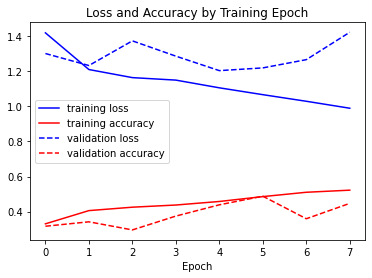

In [52]:
plot_history(range(len(model4_history.history['accuracy'])), model4_history, 'model4_v5_history')

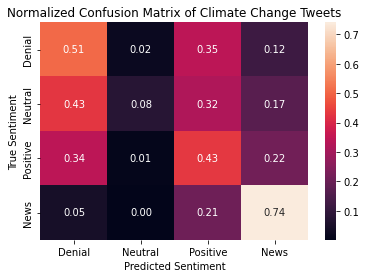

In [53]:
plot_confusion_matrix(confusion_matrix(np.array(y_test -1 ), mode14_predictions.argmax(axis=1)), 'model4_v5_conf_matrix')

<h2>Model 5</h2>

In [54]:
counts = sklearn.feature_extraction.text.CountVectorizer(max_features = 5000, ngram_range=(1, 3))
X_train_input = counts.fit_transform(X_train)
X_test_input = counts.transform(X_test)
X_val_input = counts.transform(X_val)

X_train_input = sparse2tensor(X_train_input)
X_test_input = sparse2tensor(X_test_input)
X_val_input = sparse2tensor(X_val_input)

In [55]:
NUM_CLASSES = y_train.nunique()
y_train_input = tf.keras.utils.to_categorical(y_train - 1, num_classes = NUM_CLASSES)
y_test_input = tf.keras.utils.to_categorical(y_test - 1, num_classes = NUM_CLASSES)
y_val_input = tf.keras.utils.to_categorical(y_val - 1, num_classes = NUM_CLASSES)

In [56]:
model5 = Sequential([
    Dense(units = 256, input_shape = (5000,), activation = 'relu'),
    Dense(128, activation = 'relu'), 
    Dropout(0.15), 
    Dense(128, activation = 'relu'),
    Dropout(0.15),
    Dense(64, activation = 'relu'),
    Dropout(0.15), 
    Dense(NUM_CLASSES, activation = 'softmax')
])

opt = tf.keras.optimizers.Adam(learning_rate = 1e-5) 
model5.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 5)
model_checkpoint = ModelCheckpoint('model_5', monitor = 'val_loss', save_best_only = True, mode = 'min')

model5_history = model5.fit(X_train_input, y_train_input, epochs = 200, batch_size = 64, 
                            callbacks = [early_stopping, model_checkpoint],
                            validation_data = (X_val_input, y_val_input))

Epoch 1/200


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_1/dense_5/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_1/dense_5/embedding_lookup_sparse/Reshape:0", shape=(None, 256), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_1/dense_5/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


42/42 [==============================] - 3s 48ms/step - loss: 1.3877 - accuracy: 0.2486 - val_loss: 1.3859 - val_accuracy: 0.2521
Epoch 2/200
42/42 [==============================] - 1s 35ms/step - loss: 1.3853 - accuracy: 0.2606 - val_loss: 1.3841 - val_accuracy: 0.2828
Epoch 3/200
42/42 [==============================] - 1s 35ms/step - loss: 1.3827 - accuracy: 0.2905 - val_loss: 1.3820 - val_accuracy: 0.3016
Epoch 4/200
42/42 [==============================] - 1s 35ms/step - loss: 1.3809 - accuracy: 0.3006 - val_loss: 1.3796 - val_accuracy: 0.3279
Epoch 5/200
42/42 [==============================] - 2s 36ms/step - loss: 1.3788 - accuracy: 0.3055 - val_loss: 1.3776 - val_accuracy: 0.3507
Epoch 6/200
42/42 [==============================] - 2s 36ms/step - loss: 1.3767 - accuracy: 0.3175 - val_loss: 1.3756 - val_accuracy: 0.3664
Epoch 7/200
42/42 [==============================] - 2s 40ms/step - loss: 1.3746 - accuracy: 0.3463 - val_loss: 1.3732 - val_accuracy: 0.3882
Epoch 8/200
42/42 

In [57]:
model5.load_weights('model_5')

In [58]:
model5.evaluate(X_test_input, y_test_input)

193/193 [==============================] - 1s 3ms/step - loss: 1.0263 - accuracy: 0.5668


[1.0263336896896362, 0.5668345093727112]

In [59]:
model5.evaluate(X_val_input, y_val_input)

193/193 [==============================] - 1s 3ms/step - loss: 1.0408 - accuracy: 0.5611


[1.0407699346542358, 0.5611498951911926]

193/193 [==============================] - 1s 2ms/step


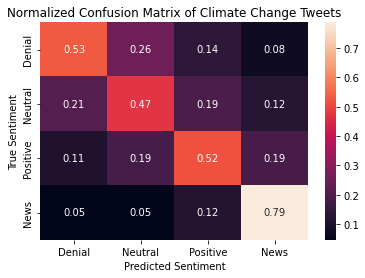

In [ ]:
model5_predictions = model5.predict(X_test_input)
plot_confusion_matrix(confusion_matrix(np.array(y_test - 1).reshape(-1, 1), model5_predictions.argmax(axis = 1)), plot_title = 'model5')

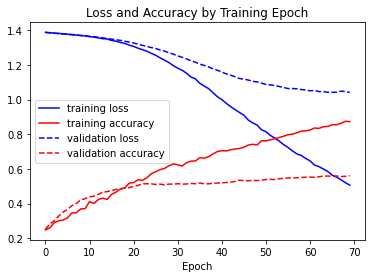

In [ ]:
plot_history(range(len(model5_history.history['accuracy'])), model5_history, 'model5_history')

<h2>Model 6</h2>

In [60]:
counts = sklearn.feature_extraction.text.CountVectorizer(max_features = 5000, ngram_range=(1, 3), lowercase = False)
X_train_input = counts.fit_transform(X_train).toarray()
X_test_input = counts.transform(X_test).toarray()
X_val_input = counts.transform(X_val).toarray()

In [61]:
model6 = Sequential([
    GRU(256, input_shape = (5000, 1), activation = 'relu', return_sequences = True), 
    GRU(128, activation = 'relu', recurrent_dropout = 0.10, return_sequences = False),
    Dense(128, activation = 'relu'), 
    Dropout(0.10), 
    Dense(64, activation = 'relu'),
    Dropout(0.10), 
    Dense(32, activation = 'relu'),
    Dense(NUM_CLASSES, activation = 'softmax')
])

opt = tf.keras.optimizers.Adam(learning_rate = 1e-2) 
model6.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 5)
model_checkpoint = ModelCheckpoint('model_6', monitor = 'val_loss', save_best_only = True, mode = 'min')

model6_history = model6.fit(X_train_input, y_train_input, epochs = 200, batch_size = 64, 
                            callbacks = [early_stopping, model_checkpoint],
                            validation_data = (X_val_input, y_val_input))

Epoch 1/200
42/42 [==============================] - 1404s 33s/step - loss: 1.3883 - accuracy: 0.2613 - val_loss: 1.3824 - val_accuracy: 0.1647
Epoch 2/200
42/42 [==============================] - 1449s 35s/step - loss: 1.3880 - accuracy: 0.2572 - val_loss: 1.3716 - val_accuracy: 0.1973
Epoch 3/200
42/42 [==============================] - 1396s 33s/step - loss: 1.3871 - accuracy: 0.2419 - val_loss: 1.3897 - val_accuracy: 0.1973
Epoch 4/200
42/42 [==============================] - 1370s 33s/step - loss: 1.3869 - accuracy: 0.2437 - val_loss: 1.3946 - val_accuracy: 0.1647
Epoch 5/200
 1/42 [..............................] - ETA: 18:30 - loss: 1.3848 - accuracy: 0.2969

In [62]:
model6.load_weights('model_6')

In [63]:
model6.evaluate(X_test_input, y_test_input)

193/193 [==============================] - 380s 2s/step - loss: 1.3720 - accuracy: 0.2035


[1.3719624280929565, 0.203508198261261]

In [64]:
model6.evaluate(X_val_input, y_val_input)

193/193 [==============================] - 373s 2s/step - loss: 1.3716 - accuracy: 0.1973


[1.3716322183609009, 0.1973363608121872]

In [ ]:
model6_predictions = model6.predict(X_test_input)
plot_confusion_matrix(confusion_matrix(np.array(y_test - 1).reshape(-1, 1), model6_predictions.argmax(axis = 1)), plot_title = 'model6')

In [ ]:
plot_history(range(len(model6_history.history['accuracy'])), model6_history, 'model6_history')